Main Leaderboard

Forecaster  | Peer score against Pros | % Beat Pros on same Qs (Bootstrap) | % Beat Pros on same Qs (Resample)

Resample: Linear interpolation of two forecasters to determine "ground truth" for resampling. "Ground truth" = weighted combination of percent forecasts on each question that yields the most accurate score. Weights are 0 to 1.

Correlation: Deal with by assigning weights to questions. Weights for independent questions are 1. "Approximately correct rather than precisely wrong." Would be good to have a rule of thumb. These weights can be used for leaderboard above.

Likely want % beat Pros to be beyond 95% for significance - but obviously a sliding scale.

Can use this method for Metaculus Track Record! Have separate line for each platform - so can see significance against each platform. Then combine all competeing platforms and treat as the same forecaster going head-to-head against Metaculus!

In [136]:
# @title Import libraries & Google drive
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import minimize_scalar
from datetime import datetime
from scipy import stats

In [137]:
df_bot_questions.head()

,bot_question_id,title,created_at,user_id,score,score_type,forecaster,is_bot,resolution,scheduled_close_time,actual_close_time,question_weight
0,25647,Which manufacturer's vehicle will return astro...,2024-06-24 17:13:26.979138+00,191956,-17.10331554202592,baseline,PredictionsToTheMoon,true,One or both remain in space beyond August 30,2024-07-20 16:00:00+00,2024-07-20 16:00:00+00,1.0
1,25647,Which manufacturer's vehicle will return astro...,2024-06-24 17:13:26.979138+00,191956,-13.92913304416501,peer,PredictionsToTheMoon,true,One or both remain in space beyond August 30,2024-07-20 16:00:00+00,2024-07-20 16:00:00+00,1.0
2,25704,Will exactly 2 Starship launches reach low-Ear...,2024-06-27 01:15:10.203983+00,187708,73.46421819520339,baseline,twsummerbot,true,yes,2024-07-01 00:00:00+00,2024-07-01 00:00:00+00,1.0
3,25704,Will exactly 2 Starship launches reach low-Ear...,2024-06-27 01:15:10.203983+00,187708,59.48217288747108,peer,twsummerbot,true,yes,2024-07-01 00:00:00+00,2024-07-01 00:00:00+00,1.0
4,25704,Will exactly 2 Starship launches reach low-Ear...,2024-06-27 01:15:10.203983+00,187708,71.32408841730857,spot_peer,twsummerbot,true,yes,2024-07-01 00:00:00+00,2024-07-01 00:00:00+00,1.0


In [138]:
# @title Create df_bot_resolved_questions, df_pro_resolved_questions, df_pro_bot_resolved_questions, df_bot_question_weights

"""
Input question data for both bots and pros.

Only look at questions that have resolved Yes or No.

df_pro_resolved_questions: Has pro_question_id, title, resolution, scheduled_close_time
df_bot_resolved_questions: Has bot_question_id, title, resolution, scheduled_close_time

All pro questions are asked to bots, but not all bot questions are asked to pros.

To compare pros to bots, we need to match the pro_question_id with the bot_question_id.
This is done by matching the title and scheduled_close_time.

We remove early closers from the analysis. To add them in at the appropriate date,
early_closing_bot_questions needs to be updated.

df_bot_question_weights has the weight of each bot_question_id, assigning 1 to
a normal question that isn't related to other questions.

df_pro_bot_resolved_questions: Has pro_question_id, bot_question_id, title, resolution, scheduled_close_time, question_weight
"""


df_bot_questions = pd.read_csv('scores/bots_score_data.csv',
                  header=0,  # Assume the first row is a header
                  na_values=[''],  # Treat empty cells as NaN
                  dtype=str)  # Read all columns as strings initially
df_bot_questions = df_bot_questions.rename(columns={'question_id': 'bot_question_id', 'question_title': 'title'})

df_pro_questions = pd.read_csv('scores/pros_score_data.csv',
                  header=0,  # Assume the first row is a header
                  na_values=[''],  # Treat empty cells as NaN
                  dtype=str)  # Read all columns as strings initially
df_pro_questions = df_pro_questions.rename(columns={'question_id': 'pro_question_id', 'question_title': 'title'})

filtered_df = df_pro_questions[df_pro_questions['resolution'].isin(['yes', 'no'])]
df_pro_resolved_questions = filtered_df[['pro_question_id', 'title', 'resolution', 'scheduled_close_time', 'actual_close_time']]
df_pro_resolved_questions['resolution'] = pd.to_numeric(df_pro_resolved_questions['resolution'], errors='coerce')
df_pro_resolved_questions['pro_question_id'] = pd.to_numeric(df_pro_resolved_questions['pro_question_id'], errors='coerce')

filtered_df = df_bot_questions[df_bot_questions['resolution'].isin(['yes', 'no'])]
df_bot_resolved_questions = filtered_df[['bot_question_id', 'title', 'resolution', 'scheduled_close_time', 'actual_close_time']]
df_bot_resolved_questions['resolution'] = pd.to_numeric(df_bot_resolved_questions['resolution'], errors='coerce')
df_bot_resolved_questions['bot_question_id'] = pd.to_numeric(df_bot_resolved_questions['bot_question_id'], errors='coerce')

df_pro_bot_resolved_questions = pd.merge(
    df_pro_resolved_questions,
    df_bot_resolved_questions[['bot_question_id', 'title', 'scheduled_close_time']],
    on=['title', 'scheduled_close_time'],
    how='left'
)

/tmp/ipykernel_1723262/2185729000.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pro_resolved_questions['resolution'] = pd.to_numeric(df_pro_resolved_questions['resolution'], errors='coerce')
/tmp/ipykernel_1723262/2185729000.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pro_resolved_questions['pro_question_id'] = pd.to_numeric(df_pro_resolved_questions['pro_question_id'], errors='coerce')
/tmp/ipykernel_1723262/2185729000.py:45: SettingWithCopyWarning: 
A value is trying to be set on a c

In [139]:
# What data type are the columns?
df_pro_bot_resolved_questions.dtypes

# Interpret the scheduled_close_time and actual_close_time as datetime
df_pro_bot_resolved_questions['scheduled_close_time'] = pd.to_datetime(df_pro_bot_resolved_questions['scheduled_close_time'])
df_pro_bot_resolved_questions['actual_close_time'] = pd.to_datetime(df_pro_bot_resolved_questions['actual_close_time'])

df_pro_bot_resolved_questions.head()

,pro_question_id,title,resolution,scheduled_close_time,actual_close_time,bot_question_id
0,25520,Will Nigel Farage be elected as a Member of Pa...,NaN,2024-07-04 11:00:00+00:00,2024-07-04 11:00:00+00:00,NaN
1,25520,Will Nigel Farage be elected as a Member of Pa...,NaN,2024-07-04 11:00:00+00:00,2024-07-04 11:00:00+00:00,NaN
2,25520,Will Nigel Farage be elected as a Member of Pa...,NaN,2024-07-04 11:00:00+00:00,2024-07-04 11:00:00+00:00,NaN
3,25520,Will Nigel Farage be elected as a Member of Pa...,NaN,2024-07-04 11:00:00+00:00,2024-07-04 11:00:00+00:00,NaN
4,25520,Will Nigel Farage be elected as a Member of Pa...,NaN,2024-07-04 11:00:00+00:00,2024-07-04 11:00:00+00:00,NaN


In [140]:

# Remove early closers (questions that resolved before the scheduled close time)
df_pro_bot_resolved_questions = df_pro_bot_resolved_questions[df_pro_bot_resolved_questions['actual_close_time'] < df_pro_bot_resolved_questions['scheduled_close_time']]


####### Create df_bot_question_weights - Can be refactored, but it works.

# Step 1: Get unique bot_question_ids from df_bot_baseline
baseline_question_ids = df_bot_resolved_questions['bot_question_id'].unique()

print(f"\n\nShape of df_pro_bot_resolved_questions: {df_pro_bot_resolved_questions.shape}\n")
print(df_pro_bot_resolved_questions.columns)

print(f"\n\nShape of df_bot_resolved_questions: {df_bot_resolved_questions.shape}\n")
print(df_bot_resolved_questions.columns)



Shape of df_pro_bot_resolved_questions: (0, 6)

Index(['pro_question_id', 'title', 'resolution', 'scheduled_close_time',
       'actual_close_time', 'bot_question_id'],
      dtype='object')


Shape of df_bot_resolved_questions: (1459, 5)

Index(['bot_question_id', 'title', 'resolution', 'scheduled_close_time',
       'actual_close_time'],
      dtype='object')


In [141]:
df_bot_resolved_questions.head()

,bot_question_id,title,resolution,scheduled_close_time,actual_close_time
2,25704,Will exactly 2 Starship launches reach low-Ear...,NaN,2024-07-01 00:00:00+00,2024-07-01 00:00:00+00
3,25704,Will exactly 2 Starship launches reach low-Ear...,NaN,2024-07-01 00:00:00+00,2024-07-01 00:00:00+00
4,25704,Will exactly 2 Starship launches reach low-Ear...,NaN,2024-07-01 00:00:00+00,2024-07-01 00:00:00+00
5,25704,Will exactly 2 Starship launches reach low-Ear...,NaN,2024-07-01 00:00:00+00,2024-07-01 00:00:00+00
6,25704,Will exactly 2 Starship launches reach low-Ear...,NaN,2024-07-01 00:00:00+00,2024-07-01 00:00:00+00


In [142]:
# @title Histogram of question weights

"""
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plot (optional, but makes it look nicer)
plt.style.use('seaborn')

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_bot_question_weights, x='question_weight', kde=False)

# Set the title and labels
plt.title('Histogram of Question Weights', fontsize=16)
plt.xlabel('Question Weight', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
"""

"\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Set the style for the plot (optional, but makes it look nicer)\nplt.style.use('seaborn')\n\n# Create the histogram\nplt.figure(figsize=(10, 6))\nsns.histplot(data=df_bot_question_weights, x='question_weight', kde=False)\n\n# Set the title and labels\nplt.title('Histogram of Question Weights', fontsize=16)\nplt.xlabel('Question Weight', fontsize=12)\nplt.ylabel('Frequency', fontsize=12)\n\n# Add grid lines for better readability\nplt.grid(True, linestyle='--', alpha=0.7)\n\n# Show the plot\nplt.tight_layout()\nplt.show()\n"

In [143]:
df_bots_scores = pd.read_csv('scores/bots_score_data.csv')
df_bots_scores.head()

,question_id,question_title,created_at,user_id,score,score_type,forecaster,is_bot,resolution,scheduled_close_time,actual_close_time,question_weight
0,25647,Which manufacturer's vehicle will return astro...,2024-06-24 17:13:26.979138+00,191956,-17.103316,baseline,PredictionsToTheMoon,True,One or both remain in space beyond August 30,2024-07-20 16:00:00+00,2024-07-20 16:00:00+00,1.0
1,25647,Which manufacturer's vehicle will return astro...,2024-06-24 17:13:26.979138+00,191956,-13.929133,peer,PredictionsToTheMoon,True,One or both remain in space beyond August 30,2024-07-20 16:00:00+00,2024-07-20 16:00:00+00,1.0
2,25704,Will exactly 2 Starship launches reach low-Ear...,2024-06-27 01:15:10.203983+00,187708,73.464218,baseline,twsummerbot,True,yes,2024-07-01 00:00:00+00,2024-07-01 00:00:00+00,1.0
3,25704,Will exactly 2 Starship launches reach low-Ear...,2024-06-27 01:15:10.203983+00,187708,59.482173,peer,twsummerbot,True,yes,2024-07-01 00:00:00+00,2024-07-01 00:00:00+00,1.0
4,25704,Will exactly 2 Starship launches reach low-Ear...,2024-06-27 01:15:10.203983+00,187708,71.324088,spot_peer,twsummerbot,True,yes,2024-07-01 00:00:00+00,2024-07-01 00:00:00+00,1.0


In [144]:
# USING SCORES DATACLIP (WAIT)

df_bots_scores = pd.read_csv('scores/bots_score_data.csv')

# Filter to only peer and baseline score types
df_bots_scores = df_bots_scores[df_bots_scores['score_type'].isin(['peer', 'baseline'])]

# First get our pivoted scores
pivot_scores = df_bots_scores.pivot_table(
    index=df_bots_scores.index,
    columns='score_type', 
    values='score'
).rename(columns={
    'baseline': 'baseline_score',
    'peer': 'peer_score'
})

# Join with original columns
result = df_bots_scores.drop(['score', 'score_type'], axis=1).join(pivot_scores)

# Collapse
group_cols = [col for col in result.columns if col not in ['baseline_score', 'peer_score']]
result = (result.groupby(group_cols, as_index=False)
          .agg({
              'baseline_score': 'first',
              'peer_score': 'first'
          }))

result.head()


,question_id,question_title,created_at,user_id,forecaster,is_bot,resolution,scheduled_close_time,actual_close_time,question_weight,baseline_score,peer_score
0,25647,Which manufacturer's vehicle will return astro...,2024-06-24 17:13:26.979138+00,191956,PredictionsToTheMoon,True,One or both remain in space beyond August 30,2024-07-20 16:00:00+00,2024-07-20 16:00:00+00,1.0,-17.103316,-13.929133
1,25704,Will exactly 2 Starship launches reach low-Ear...,2024-06-27 01:15:10.203983+00,187708,twsummerbot,True,yes,2024-07-01 00:00:00+00,2024-07-01 00:00:00+00,1.0,73.464218,59.482173
2,25704,Will exactly 2 Starship launches reach low-Ear...,2024-06-27 01:15:10.203983+00,188103,botaska,True,yes,2024-07-01 00:00:00+00,2024-07-01 00:00:00+00,1.0,31.152269,21.835163
3,25704,Will exactly 2 Starship launches reach low-Ear...,2024-06-27 01:15:10.203983+00,188775,amaster1997,True,yes,2024-07-01 00:00:00+00,2024-07-01 00:00:00+00,1.0,-13.188835,-12.554379
4,25704,Will exactly 2 Starship launches reach low-Ear...,2024-06-27 01:15:10.203983+00,189585,mf-bot-1,True,yes,2024-07-01 00:00:00+00,2024-07-01 00:00:00+00,1.0,-80.221061,-72.708615


In [145]:
# Step 1: Read in the scores dataclips from heroku, take last (spot) score for each question_id, forecaster pair; make it into what Tom's code expects

## BOTS

df_bot_scores = pd.read_csv('scores/bots_score_data.csv')

# BASELINE
df_bot_baseline = df_bot_scores[df_bot_scores['score_type'] == 'baseline']

# Take the LAST score for each (forecaster, question_id) pair
df_bot_baseline = df_bot_baseline.groupby(['question_id', 'forecaster']).last().reset_index()

# PEER
df_bot_peer = df_bot_scores[df_bot_scores['score_type'] == 'peer']

# Take the LAST score for each (forecaster, question_id) pair
df_bot_peer = df_bot_peer.groupby(['question_id', 'forecaster']).last().reset_index()

## PROS

df_pros_scores = pd.read_csv('scores/pros_score_data.csv')

# BASELINE
df_pros_baseline = df_pros_scores.groupby(['question_id', 'forecaster']).last().reset_index()

# Take the LAST score for each (forecaster, question_id) pair
df_pros_baseline = df_pros_baseline.groupby(['question_id', 'forecaster']).last().reset_index()

df_pros_peer = df_pros_scores[df_pros_scores['score_type'] == 'peer']

# ADD THE BOT MEDIAN SPOT SCORE & REMOVE UNNECESSARY COLUMNS
df_bot_baseline = df_bot_baseline[['question_id', 'question_title', 'question_weight', 'forecaster', 'score']]

# Calculate medians and preserve metadata
medians = (df_bot_baseline
    .groupby(['question_id', 'question_title', 'question_weight'])['score']
    .median()
    .reset_index()
    .assign(forecaster='bot_median')
)

# Combine with original data
df_bot_baseline = pd.concat([df_bot_baseline, medians])

# DO THE SAME FOR DF_BOT_PEER
df_bot_peer = df_bot_peer[['question_id', 'question_title', 'question_weight', 'forecaster', 'score']]

# Get all columns except score and forecaster
medians = (df_bot_peer
    .groupby(['question_id', 'question_title', 'question_weight'])['score']
    .median()
    .reset_index()
    .assign(forecaster='bot_median')
)

# Combine with original data
df_bot_peer = pd.concat([df_bot_peer, medians])

df_bot_baseline.head()


,question_id,question_title,question_weight,forecaster,score
0,25647,Which manufacturer's vehicle will return astro...,1.0,PredictionsToTheMoon,-17.103316
1,25704,Will exactly 2 Starship launches reach low-Ear...,1.0,VeritasAI,-1.530229
2,25704,Will exactly 2 Starship launches reach low-Ear...,1.0,amaster1997,-13.188835
3,25704,Will exactly 2 Starship launches reach low-Ear...,1.0,botaska,31.152269
4,25704,Will exactly 2 Starship launches reach low-Ear...,1.0,mf-bot-1,-80.221061


In [146]:
# WHICH QUESTIONS ARE IN DF_BOT_BASELINE BUT NOT IN DF_PROs_BASELINE?
bot_baseline_question_ids = df_bot_baseline['question_id'].unique()
pros_baseline_question_ids = df_pros_baseline['question_id'].unique()
questions_only_in_bot = set(bot_baseline_question_ids) - set(pros_baseline_question_ids)

import numpy as np
from scipy import stats

def calculate_weighted_stats(df):
    results = []
    
    # For each forecaster
    for forecaster in df['forecaster'].unique():
        forecaster_data = df[df['forecaster'] == forecaster]
        
        # Get scores and weights
        scores = forecaster_data['score']
        weights = forecaster_data['question_weight']
        
        # Calculate weighted mean
        weighted_mean = np.average(scores, weights=weights)
        
        # Calculate weighted standard error
        # Using weighted variance formula
        weighted_var = np.average((scores - weighted_mean)**2, weights=weights)
        n = len(scores)
        weighted_se = np.sqrt(weighted_var / n)
        
        # Calculate t-statistic for 95% confidence interval
        t_value = stats.t.ppf(0.975, n-1)
        ci_lower = weighted_mean - (t_value * weighted_se)
        
        results.append({
            'forecaster': forecaster,
            'weighted_mean': weighted_mean,
            'n_questions': n,
            'ci_lower': ci_lower,
            'weighted_se': weighted_se
        })
    
    # Convert to dataframe and sort by lower bound
    results_df = pd.DataFrame(results)
    return results_df.sort_values('ci_lower', ascending=False)

# Calculate and show results
ranked_forecasters = calculate_weighted_stats(df_bot_baseline)

ranked_forecasters.head(10)

,forecaster,weighted_mean,n_questions,ci_lower,weighted_se
30,pgodzinai,43.706863,13,26.335416,7.972896
43,bot_median,18.368352,27,8.799506,4.655173
18,Jay_Bailey_Bot,19.966389,16,6.783939,6.184735
17,HSeldon,21.861061,16,5.941631,7.468828
7,royal7,51.009342,4,5.762458,14.217643
21,RonanMcGovern,11.302601,16,5.136578,2.892878
6,twsummerbot,21.811679,16,3.641320,8.524883
19,MWG,2.382130,16,0.274420,0.988862
1,VeritasAI,19.648170,17,0.180447,9.183299
29,manticAI,0.425473,11,0.128135,0.133447


In [147]:
# DO THE TEAMING THING NEXT TK

In [148]:
# @title Create df_bot_baseline, df_bot_peer, df_bot_forecasts, bots

"""
df_bot_baseline: Spot Baseline scores for all bots & bot_median

df_bot_peer: Spot Peer scores for all bots & bot_median. Can be used to recreate
the tournament leaderboard on the site.

df_bot_forecasts: Spot forecasts for all bots & bot_median, ie only counts the
final forecast

bots: a list of all bots
"""

# Pivot df_bot_baseline
df_bot_baseline = df_bot_baseline.rename(columns={'question_id': 'bot_question_id'})
#df_bot_baseline['score'] = pd.to_numeric(df_bot_baseline['score'], errors='coerce')
df_pivoted = df_bot_baseline.pivot(index='bot_question_id', columns='forecaster', values='score')
df_pivoted = df_pivoted.reset_index()
df_pivoted = df_pivoted.reindex(sorted(df_pivoted.columns), axis=1)

# Move 'question_id' to be the first column
cols = df_pivoted.columns.tolist()
cols = ['bot_question_id'] + [col for col in cols if col != 'bot_question_id']
df_pivoted = df_pivoted[cols]

all_columns = df_pivoted.columns.tolist()
# Remove 'question_id' and 'bot_median' from the list if they exist
all_columns = [col for col in all_columns if col not in ['bot_question_id', 'bot_median']]
new_column_order = ['bot_question_id', 'bot_median'] + all_columns
df_pivoted = df_pivoted[new_column_order]
df_bot_baseline = df_pivoted
df_bot_baseline['bot_question_id'] = pd.to_numeric(df_bot_baseline['bot_question_id'], errors='coerce')

# Create df_bot_peer
df_bot_peer = df_bot_peer.rename(columns={'question_id': 'bot_question_id'})
df_bot_peer['score'] = pd.to_numeric(df_bot_peer['score'], errors='coerce')
df_pivoted = df_bot_peer.pivot(index='bot_question_id', columns='forecaster', values='score')
df_pivoted = df_pivoted.reset_index()
df_pivoted = df_pivoted.reindex(sorted(df_pivoted.columns), axis=1)

# Step 4: Move 'question_id' to be the first column
cols = df_pivoted.columns.tolist()
cols = ['bot_question_id'] + [col for col in cols if col != 'bot_question_id']
df_pivoted = df_pivoted[cols]

all_columns = df_pivoted.columns.tolist()
## Remove 'question_id' and 'bot_median' from the list if they exist
all_columns = [col for col in all_columns if col not in ['bot_question_id', 'bot_median']]
new_column_order = ['bot_question_id', 'bot_median'] + all_columns
df_pivoted = df_pivoted[new_column_order]
df_bot_peer = df_pivoted
#df_bot_peer['bot_question_id'] = pd.to_numeric(df_bot_peer['bot_question_id'], errors='coerce')
#df_bot_peer = pd.merge(
    #df_bot_peer,
    #df_bot_question_weights,
    #on='bot_question_id',
    #how='left'
#)

#print(f"Shape of df_bot_baseline: {df_bot_baseline.shape}")
#print(df_bot_baseline.columns)

#print(f"\n")

#print(f"Shape of df_bot_peer: {df_bot_baseline.shape}")
#print(df_bot_baseline.columns)


In [149]:
df_bot_peer.head()

forecaster,bot_question_id,bot_median,000_bot,Bot_Pepa,Cassie,Ethiventure,GMEToTheMoon,HSeldon,InstitutPelFutur,Jay_Bailey_Bot,...,mf-bot-2,nikolabot,p-bot,peacefulwarrior+bot,pgodzinai,pythoness,reproducible,royal7,silicoqr,twsummerbot
0,25647,-13.929133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25704,1.972829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.900007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.482173
2,25713,4.638210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.046270,NaN,NaN
3,25743,-1.388959,NaN,NaN,-8.910958,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.217413,NaN,NaN,NaN,NaN,4.009452,-1.388959,NaN
4,25749,-5.385389,NaN,NaN,-6.917169,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.853608,NaN


In [99]:
df_bot_baseline.head()

forecaster,bot_question_id,bot_median,000_bot,Bot_Pepa,Cassie,Ethiventure,GMEToTheMoon,HSeldon,InstitutPelFutur,Jay_Bailey_Bot,...,mf-bot-2,nikolabot,p-bot,peacefulwarrior+bot,pgodzinai,pythoness,reproducible,royal7,silicoqr,twsummerbot
0,25647,-17.103316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25704,2.012779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.555788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.464218
2,25713,22.770598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.232197,NaN,NaN
3,25743,85.063180,NaN,NaN,21.917266,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,97.484972,NaN,NaN,NaN,NaN,89.094142,8.899289,NaN
4,25749,14.985044,NaN,NaN,24.039272,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.930816,NaN


In [150]:

################ CONVERT BASELINE SCORE TO FORECAST ###################

def convert_baseline_to_forecasts(df):
    # Assumes columns: 'bot_question_id' 'resolution_internal'
    result_df = df.copy()

    def score_to_forecast(score, resolution):
        if resolution == 1.0:
            return 2 ** (score/100 - 1)
        else:
            return 1 - 2 ** (score/100 - 1)

    score_columns = df.columns.tolist()
    score_columns = [col for col in score_columns if col not in ['bot_question_id', 'resolution', 'pro_question_id']]

    for col in score_columns:
        result_df[col] = result_df.apply(lambda row: score_to_forecast(row[col], row['resolution']), axis=1)

    return result_df

df_temp = pd.merge(
    df_bot_baseline,
    df_bot_resolved_questions[['bot_question_id', 'resolution']],
    on='bot_question_id',
    how='left'
)

df_bot_forecasts = convert_baseline_to_forecasts(df_temp)
df_bot_forecasts = df_bot_forecasts.drop('resolution', axis=1)

#print(f"Shape of df_bot_forecasts: {df_bot_forecasts.shape}")
#print(df_bot_forecasts.columns)

bots = df_bot_forecasts.columns
bots = bots.drop(['bot_median', 'bot_question_id'])
#print(bots)

#print(df_bot_peer)

In [151]:
# @title Bot Baseline Leaderboard

# Calculate the total score for each bot
total_scores = df_bot_baseline.iloc[:, 1:].fillna(0).sum()

# Create a new dataframe with the total scores
df_total_scores = pd.DataFrame({'Bot': total_scores.index, 'Baseline_Score': total_scores.values})

# Sort the dataframe by Total_Score in descending order
df_total_scores_sorted = df_total_scores.sort_values('Baseline_Score', ascending=False)

# Add a Rank column
df_total_scores_sorted['Rank'] = range(1, len(df_total_scores_sorted) + 1)

# Set Rank as the index
df_total_scores_ranked = df_total_scores_sorted.set_index('Rank')

# Display the result
#print(df_total_scores_ranked)

In [152]:
df_total_scores_sorted

,Bot,Baseline_Score,Rank
38,pgodzinai,568.189222,1
33,mf-bot-1,500.096358,2
0,bot_median,495.945491,3
3,Cassie,383.805991,4
2,Bot_Pepa,358.225400,5
6,HSeldon,349.776978,6
43,twsummerbot,348.986859,7
29,jkraybill_bot,344.038151,8
16,VeritasAI,334.018897,9
8,Jay_Bailey_Bot,319.462224,10


In [153]:
df_filled = df_bot_peer.fillna(0)
df_filled.head()

forecaster,bot_question_id,bot_median,000_bot,Bot_Pepa,Cassie,Ethiventure,GMEToTheMoon,HSeldon,InstitutPelFutur,Jay_Bailey_Bot,...,mf-bot-2,nikolabot,p-bot,peacefulwarrior+bot,pgodzinai,pythoness,reproducible,royal7,silicoqr,twsummerbot
0,25647,-13.929133,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,25704,1.972829,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,6.900007,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,59.482173
2,25713,4.638210,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,4.046270,0.000000,0.000000
3,25743,-1.388959,0.0,0.0,-8.910958,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,5.217413,0.0,0.0,0.0,0.0,4.009452,-1.388959,0.000000
4,25749,-5.385389,0.0,0.0,-6.917169,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,-3.853608,0.000000


In [155]:
# @title Bot Peer Leaderboard

"""
NOTE: This can be different from the leaderboad on the site since early closers
are excluded.
"""

df_filled = df_bot_peer.fillna(0)
#df_filled = df_filled.drop(['bot_question_id', 'question_weight'], axis=1)

# Calculate the total score for each player
total_scores = df_filled.sum()

# Create a new DataFrame for the leaderboard
leaderboard = pd.DataFrame({
    'bot': total_scores.index,
    'Peer Score': total_scores.values
})

In [156]:
# Sort the leaderboard by Total Score in descending order
leaderboard = leaderboard.sort_values('Peer Score', ascending=False)

# Reset the index and add a 'Rank' column
leaderboard = leaderboard.reset_index(drop=True)
leaderboard.index += 1
leaderboard.index.name = 'Rank'

# Display the leaderboard
#print(leaderboard)

In [158]:
# @title Create df_pro_baseline, df_pro_forecasts

"""
WARNING: This may not exclude early closers.

df_pro_baseline: Spot Baseline scores for all pros & pro_median

df_pro_forecasts: Spot forecasts for all pros & pro_median
"""


df_pro_scores = pd.read_csv('scores/pros_score_data.csv')

# Pivot df_pro_scores (baseline)
df_pro_scores = df_pro_scores.rename(columns={'question_id': 'pro_question_id'})
df_pivoted = df_pro_scores.pivot(index='pro_question_id', columns='forecaster', values='score')
df_pivoted = df_pivoted.reset_index()
df_pivoted = df_pivoted.reindex(sorted(df_pivoted.columns), axis=1)

cols = df_pivoted.columns.tolist()
cols = ['pro_question_id'] + [col for col in cols if col != 'pro_question_id']
df_pivoted = df_pivoted[cols]
df_pivoted = df_pivoted.drop(['community_geometric_mean', 'community_prediction'], axis=1)
df_pivoted = df_pivoted.rename(columns={'community_prediction_unweighted': 'pro_median'})
all_columns = df_pivoted.columns.tolist()
all_columns = [col for col in all_columns if col not in ['pro_question_id', 'pro_median']]
new_column_order = ['pro_question_id', 'pro_median'] + all_columns
df_pivoted = df_pivoted[new_column_order]
df_pro_baseline = df_pivoted
df_pro_baseline['pro_question_id'] = pd.to_numeric(df_pro_baseline['pro_question_id'], errors='coerce')


#print(f"Shape of df_pro_baseline: {df_pro_baseline.shape}")
#print(df_pro_baseline.columns)


df_temp = pd.merge(
    df_pro_baseline,
    df_pro_resolved_questions[['pro_question_id', 'resolution_internal']],
    on='pro_question_id',
    how='left'
)

df_pro_forecasts = convert_baseline_to_forecasts(df_temp)
df_pro_forecasts = df_pro_forecasts.drop('resolution_internal', axis=1)

#print(f"Shape of df_pro_forecasts: {df_pro_forecasts.shape}")
#print(df_pro_forecasts.columns)


ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
# @title Create df_pro_bot_forecasts, df_bot_vs_pro_peer, df_bot_vs_pro_leaderboard, df_bot_vs_pro_weighted_leaderboard

"""
df_pro_bot_forecasts: Spot forecasts for all bots & pro_median, question resolutions, and question weights

df_bot_vs_pro_peer: Calculates Peer scores as if there is a tournament with only
a single bot and the pro_median. This is the main comparison metric for
assessing how a bot compares to the human aggregate. Positive scores mean that
the bot did better than the pro_median. Negative scores mean that the bot did
worse than the pro_median.

df_bot_vs_pro_leaderboard: A leaderboard based on df_bot_vs_pro_peer.

df_bot_vs_pro_weighted_leaderboard: A leaderboard based on df_bot_vs_pro_peer
with question weighting.
"""

# ADD BOT_TEAM_MEDIAN TO df_pro_bot_forecasts




df2 = pd.merge(
    df_pro_bot_resolved_questions[['pro_question_id', 'bot_question_id', 'resolution_internal']],
    df_pro_forecasts[['pro_question_id', 'pro_median']],
    on='pro_question_id',
    how='left'
)

df_pro_bot_forecasts = pd.merge(
    df2,
    df_bot_forecasts,
    on='bot_question_id',
    how='left'
)

df_pro_bot_forecasts = pd.merge(
    df_pro_bot_forecasts,
    df_bot_question_weights,
    on='bot_question_id',
    how='left'
)

bot_team = ["FJ_Researcher01+bot", "VeritasAI", "MWG", "annabot", "twsummerbot", "histerio", "acm_bot", "Jay_Bailey_Bot", "HSeldon", "pgodzinai"]

# Create the bot_team_median column
df_pro_bot_forecasts["bot_team_median"] = df_pro_bot_forecasts[bot_team].median(axis=1)


#print(f"Shape of df_pro_bot_forecasts: {df_pro_bot_forecasts.shape}")
#print(df_pro_bot_forecasts.columns)

# Create a new DataFrame to store peer scores
df_bot_vs_pro_peer = df_pro_bot_forecasts.copy()
df_bot_vs_pro_peer = df_bot_vs_pro_peer[['pro_median', 'resolution_internal', 'question_weight', 'bot_question_id']]

# Calculate peer score for each bot
for bot in bots:
    # Calculate Head-to-head score based on the condition
    peer_score = np.where(
        df_pro_bot_forecasts['resolution_internal'] == 1,
        np.log(df_pro_bot_forecasts[bot] / df_pro_bot_forecasts['pro_median']),
        np.log((1 - df_pro_bot_forecasts[bot]) / (1 - df_pro_bot_forecasts['pro_median']))
    )

    # Add the calculated peer score to the new DataFrame
    df_bot_vs_pro_peer[bot] = 100 * peer_score

# Calculate Head-to-head score for bot_team
peer_score = np.where(
    df_pro_bot_forecasts['resolution_internal'] == 1,
    np.log(df_pro_bot_forecasts['bot_team_median'] / df_pro_bot_forecasts['pro_median']),
    np.log((1 - df_pro_bot_forecasts['bot_team_median']) / (1 - df_pro_bot_forecasts['pro_median']))
)

# Add the calculated peer score to the new DataFrame
df_bot_vs_pro_peer["bot_team_median"] = 100 * peer_score


total_scores = df_bot_vs_pro_peer.sum(axis=0)
weighted_scores = df_bot_vs_pro_peer.mul(df_pro_bot_forecasts['question_weight'], axis=0).sum(axis=0)

# Calculate number of questions answered by each bot
num_questions = df_bot_vs_pro_peer.apply(lambda col: col[col.notna() & col.apply(np.isreal)].count())
#num_weighted_questions = df_bot_vs_pro_peer.mul(df_pro_bot_forecasts['question_weight'], axis=0).apply(lambda col: col[col.notna() & col.apply(np.isreal)].count())

# Create a new DataFrame with the results
results = pd.DataFrame({
    'Peer_vs_Pro': total_scores,
    'Count': num_questions
})

weighted_results = pd.DataFrame({
    'W_Peer_vs_Pro': weighted_scores,
    'Count': num_questions
})

df_bot_vs_pro_leaderboard = results.sort_values(by='Peer_vs_Pro', ascending=False)
df_bot_vs_pro_weighted_leaderboard = weighted_results.sort_values(by='W_Peer_vs_Pro', ascending=False)

#print(df_bot_vs_pro_leaderboard)
#print("\n\n")
#print(df_bot_vs_pro_weighted_leaderboard)


In [ ]:
# @title Create df_pro_bot_baseline_leaderboard, df_pro_bot_baseline_weighted_leaderboard

df_pro_bot_baseline_weights = pd.merge(
    df_pro_bot_resolved_questions,
    df_bot_baseline,
    on='bot_question_id',
    how='left'
)

df_pro_bot_baseline_weights = pd.merge(
    df_pro_bot_baseline_weights,
    df_pro_baseline[['pro_question_id', 'pro_median']],
    on='pro_question_id',
    how='left'
)

#print(df_pro_bot_baseline_weights)

# Create a list of columns to keep
columns_to_keep = ['pro_median'] + ['question_weight'] + [col for col in df_pro_bot_baseline_weights.columns if col in bots]
df_filtered = df_pro_bot_baseline_weights[columns_to_keep]

# Calculate the sum for each forecaster
forecaster_scores = df_filtered.sum()
forecaster_weighted_scores = df_filtered.mul(df_filtered['question_weight'], axis=0).sum()

question_counts = df_filtered.notna().sum()

# Create a DataFrame for the leaderboard
leaderboard = pd.DataFrame({
    'Forecaster': forecaster_scores.index,
    'Baseline': forecaster_scores.values,
    'Count': question_counts.values
})

# Create a DataFrame for the leaderboard
weighted_leaderboard = pd.DataFrame({
    'Forecaster': forecaster_weighted_scores.index,
    'Weighted_Baseline': forecaster_weighted_scores.values,
    'Count': question_counts.values
})

# Sort the leaderboard by score in descending order
leaderboard = leaderboard.sort_values('Baseline', ascending=False).reset_index(drop=True)
weighted_leaderboard = weighted_leaderboard.sort_values('Weighted_Baseline', ascending=False).reset_index(drop=True)

# Add a 'Rank' column
leaderboard['Rank'] = leaderboard.index + 1
weighted_leaderboard['Rank'] = weighted_leaderboard.index + 1

# Reorder columns to have Rank first
leaderboard = leaderboard[['Rank', 'Forecaster', 'Baseline', 'Count']]
weighted_leaderboard = weighted_leaderboard[['Rank', 'Forecaster', 'Weighted_Baseline', 'Count']]

# Display the leaderboard
#print(leaderboard)
#print("\n\n")
#print(weighted_leaderboard)

In [ ]:
# @title function t_critical_value

def t_critical_value(df):
    # Dictionary containing t-values for 95% confidence interval (2-tailed)
    t_table = {
        1: 12.706, 2: 4.303, 3: 3.182, 4: 2.776, 5: 2.571,
        6: 2.447, 7: 2.365, 8: 2.306, 9: 2.262, 10: 2.228,
        11: 2.201, 12: 2.179, 13: 2.160, 14: 2.145, 15: 2.131,
        16: 2.120, 17: 2.110, 18: 2.101, 19: 2.093, 20: 2.086,
        21: 2.080, 22: 2.074, 23: 2.069, 24: 2.064, 25: 2.060,
        26: 2.056, 27: 2.052, 28: 2.048, 29: 2.045, 30: 2.042,
        40: 2.021, 50: 2.009, 60: 2.000, 70: 1.994, 80: 1.990,
        90: 1.987, 100: 1.984, 1000: 1.962, float('inf'): 1.960
    }

    # Check if df is in the table
    if df in t_table:
        return t_table[df]

    # If df is not in the table, find the closest lower df
    lower_df = max(key for key in t_table.keys() if key <= df)

    # If df is between two values, perform linear interpolation
    if lower_df < df:
        upper_df = min(key for key in t_table.keys() if key > df)
        lower_t = t_table[lower_df]
        upper_t = t_table[upper_df]

        # Linear interpolation
        t_value = lower_t + (upper_t - lower_t) * (df - lower_df) / (upper_df - lower_df)
        return round(t_value, 3)

    return t_table[lower_df]


# Example usage
#print(f"Critical t-value for df=3.5: {t_critical_value(3.5)}")
#print(f"Critical t-value for df=35: {t_critical_value(35)}")
#print(f"Critical t-value for df=200: {t_critical_value(200)}")

In [ ]:
# @title Weighted head-to-head, T test

"""
df_W_leaderboard: A leaderboard based on df_bot_vs_pro_peer with question
weighting and the calculations for doing doing a weighted T test

"""

df_W_leaderboard = pd.DataFrame()

df3 = pd.DataFrame()

for bot in bots:

  # T test
  df3 = df_bot_vs_pro_peer.copy()
  df3 = df_bot_vs_pro_peer[[bot, 'question_weight']]
  #df3['question_weight'] = 1
  df3 = df3.dropna()
  df3 = df3.reset_index(drop=True)
  weighted_score = (df3[bot] * df3['question_weight']).sum()
  weighted_count = df3['question_weight'].sum()
  weighted_average = weighted_score / weighted_count
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
  std_error = weighted_std_dev / np.sqrt(weighted_count)
  t_statistic = (weighted_average - 0) / std_error
  if weighted_count > 2:
    t_crit = t_critical_value(weighted_count - 1)
    # 95% confidence that the true mean is between lower and upper bounds
    upper_bound = weighted_average + t_crit * std_error
    lower_bound = weighted_average - t_crit * std_error
    # 1.96 sigma for a normal Gaussian correponds to 97.5th percentile
    # Normalization below
    cdf = norm.cdf(t_statistic * 1.96 / t_crit)
  else:
    t_crit = np.NaN
    upper_bound = np.NaN
    lower_bound = np.NaN
    cdf = np.NaN

  df_W_leaderboard.loc[bot, 'W_score'] = weighted_score
  df_W_leaderboard.loc[bot, 'W_count'] = weighted_count
  df_W_leaderboard.loc[bot, 'W_ave'] = weighted_average
  df_W_leaderboard.loc[bot, 'W_stdev'] = weighted_std_dev
  df_W_leaderboard.loc[bot, 'std_err'] = std_error
  df_W_leaderboard.loc[bot, 't_stat'] = t_statistic
  df_W_leaderboard.loc[bot, 't_crit'] = t_crit
  df_W_leaderboard.loc[bot, 'upper_bound'] = upper_bound
  df_W_leaderboard.loc[bot, 'lower_bound'] = lower_bound
  df_W_leaderboard.loc[bot, 'cdf'] = cdf * 100


#print(df_W_leaderboard[['Peer_vs_Pro', 'Count',  'bootstrap',  'resample',  'cdf']])
#print('\n\n')
#print(df_W_leaderboard[['W_score', 'W_count', 'W_ave',  'W_stdev',  'std_err',  't_stat',  'cdf']].sort_values(by='W_score', ascending=False))

print(df_W_leaderboard.sort_values(by='W_score', ascending=False))


<ipython-input-37-5010e8e09d8c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['question_weight'] = 1
<ipython-input-37-5010e8e09d8c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['question_weight'] = 1
<ipython-input-37-5010e8e09d8c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

                         W_score  W_count      W_ave     W_stdev    std_err  \
nikolabot             296.033170      5.0  59.206634  129.410238  57.874018   
silicoqr                0.000000      0.0        NaN   -0.000000        NaN   
letfd_bot2              0.000000      0.0        NaN   -0.000000        NaN   
christian+botJune7      0.000000      0.0        NaN   -0.000000        NaN   
botSep20b               0.000000      0.0        NaN   -0.000000        NaN   
royal7                 -7.571182      1.0  -7.571182         NaN        NaN   
p-bot                 -78.534799      3.0 -26.178266   34.465449  19.898637   
egriffiths           -155.640356      5.0 -31.128071   56.560443  25.294599   
ProfPaul             -190.893438     35.0  -5.454098   77.124678  13.036450   
kiko-bot             -257.130325     47.0  -5.470858   74.412860  10.854231   
SynapseSeer          -285.346102     23.0 -12.406352   73.531631  15.332405   
lapp0                -313.104737     23.0 -13.613249

<ipython-input-37-5010e8e09d8c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['question_weight'] = 1
<ipython-input-37-5010e8e09d8c>:23: RuntimeWarning: invalid value encountered in scalar divide
  weighted_average = weighted_score / weighted_count
<ipython-input-37-5010e8e09d8c>:25: RuntimeWarning: invalid value encountered in scalar divide
  std_error = weighted_std_dev / np.sqrt(weighted_count)
<ipython-input-37-5010e8e09d8c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['question_weight'

In [ ]:
# @title Weighted Bot Peer, T test


df_W_bot_peer_leaderboard = pd.DataFrame()

df3 = pd.DataFrame()

df_bot_only_peer = df_bot_peer.copy()


for bot in bots:

  # T test
  df3 = df_bot_peer[[bot, 'question_weight']]
  df3 = df3.dropna()
  df3 = df3.reset_index(drop=True)
  weighted_score = (df3[bot] * df3['question_weight']).sum()
  weighted_count = df3['question_weight'].sum()
  weighted_average = weighted_score / weighted_count
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
  std_error = weighted_std_dev / np.sqrt(weighted_count)
  t_statistic = (weighted_average - 0) / std_error
  if weighted_count > 2:
    t_crit = t_critical_value(weighted_count - 1)
    # 95% confidence that the true mean is between lower and upper bounds
    upper_bound = weighted_average + t_crit * std_error
    lower_bound = weighted_average - t_crit * std_error
    # 1.96 sigma for a normal Gaussian correponds to 97.5th percentile
    # Normalization below
    cdf = norm.cdf(t_statistic * 1.96 / t_crit)
  else:
    t_crit = np.NaN
    upper_bound = np.NaN
    lower_bound = np.NaN
    cdf = np.NaN

  df_W_leaderboard.loc[bot, 'W_score'] = weighted_score
  df_W_leaderboard.loc[bot, 'W_count'] = weighted_count
  df_W_leaderboard.loc[bot, 'W_ave'] = weighted_average
  df_W_leaderboard.loc[bot, 'W_stdev'] = weighted_std_dev
  df_W_leaderboard.loc[bot, 'std_err'] = std_error
  df_W_leaderboard.loc[bot, 't_stat'] = t_statistic
  df_W_leaderboard.loc[bot, 't_crit'] = t_crit
  df_W_leaderboard.loc[bot, 'upper_bound'] = upper_bound
  df_W_leaderboard.loc[bot, 'lower_bound'] = lower_bound
  df_W_leaderboard.loc[bot, 'cdf'] = cdf * 100


#print(df_W_leaderboard[['Peer_vs_Pro', 'Count',  'bootstrap',  'resample',  'cdf']])
#print('\n\n')
#print(df_W_leaderboard[['W_score', 'W_count', 'W_ave',  'W_stdev',  'std_err',  't_stat',  'cdf']].sort_values(by='W_score', ascending=False))


print(df_W_leaderboard[['W_score', 'W_count']].sort_values(by='W_score', ascending=False))

print(df_W_leaderboard.sort_values(by='W_score', ascending=False))



                          W_score     W_count
FJ_Researcher01+bot   3354.790423  243.320308
histerio              2876.273782  213.379802
mf-bot-1              2829.838121  251.282308
MWG                   2572.857585  251.832241
Jay_Bailey_Bot        2532.598948  252.908123
pgodzinai             2369.243689  233.965618
twsummerbot           1987.875870  253.936444
RonanMcGovern         1981.646691  255.436444
annabot               1928.752636  251.436444
mf-bot-3              1657.749353  195.566023
acm_bot               1552.513422  173.119736
Unwrapped80T          1338.255600  121.491592
VeritasAI             1080.498482  251.079156
Panshul42             1075.077438   99.608370
HSeldon                886.874512  254.908123
archipelago            802.122071  182.991367
InstitutPelFutur       659.728179  235.664717
centobot               638.026485  137.042014
Tsbot                  527.629012   49.021027
doland                 406.054451  126.789353
ProfPaul               373.642880 

<ipython-input-15-7d3d160fc30a>:20: RuntimeWarning: invalid value encountered in scalar divide
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))


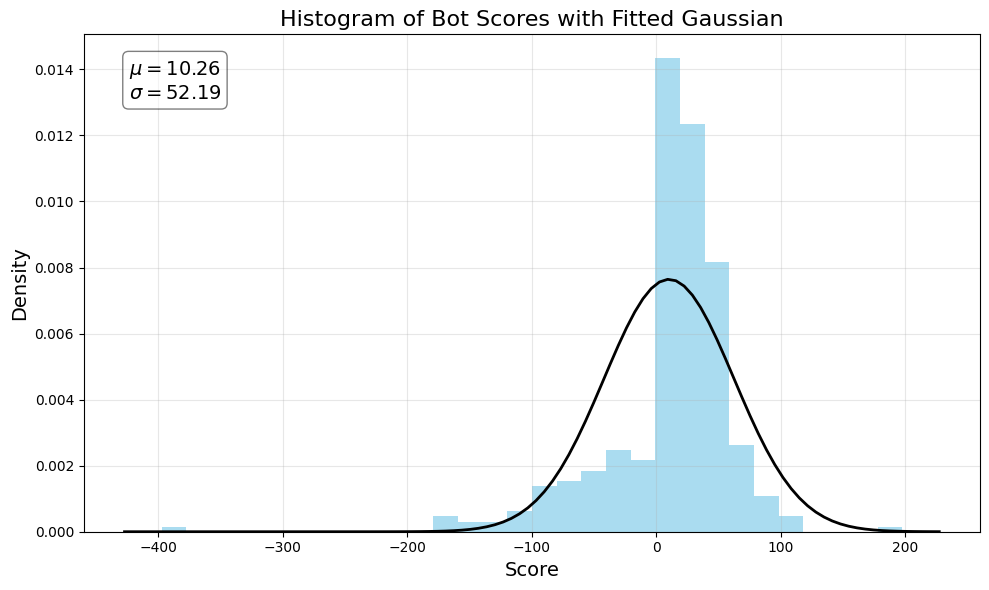

In [ ]:
# @title Histogram of bot

# Extract the 'mf-bot-1' column and remove NaN values
#scores = df_bot_vs_pro_peer['FJ_Researcher01+bot'].dropna()
scores = df_bot_peer['mf-bot-1'].dropna()

# Create the histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(scores, bins=30, density=True, alpha=0.7, color='skyblue')

# Fit a normal distribution to the data
mu, std = norm.fit(scores)

# Plot the PDF of the fitted normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Customize the plot
plt.title("Histogram of Bot Scores with Fitted Gaussian", fontsize=16)
plt.xlabel("Score", fontsize=14)
plt.ylabel("Density", fontsize=14)

# Add text box with distribution parameters
textstr = f'$\mu={mu:.2f}$\n$\sigma={std:.2f}$'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# @title Bootstrapping

def weighted_bootstrap_analysis(df_bot_peer, bots, NUM, ITER):
    # Function to perform a single bootstrap iteration
    def single_bootstrap(df):
        # Weighted sampling of questions
        sampled_df = df.sample(n=NUM, weights='question_weight', replace=True)
        # Calculate total weighted score for each bot
        return sampled_df[bots].sum()

    # Perform bootstrap ITER times
    bootstrap_results = [single_bootstrap(df_bot_peer) for _ in range(ITER)]

    # Convert results to DataFrame
    results_df = pd.DataFrame(bootstrap_results)

    # Calculate confidence intervals and median
    ci_low = results_df.quantile(0.025)
    ci_10 = results_df.quantile(0.1)
    ci_high = results_df.quantile(0.975)
    ci_90 = results_df.quantile(0.9)
    median = results_df.median()

    # Create output DataFrame
    output_df = pd.DataFrame({
        '2.5% CI': ci_low,
        '10% CI': ci_10,
        'Median': median,
        '90% CI': ci_90,
        '97.5% CI': ci_high
    })

    # Sort by median descending
    output_df = output_df.sort_values('Median', ascending=False)

    return output_df

NUM = round(df_bot_peer['question_weight'].sum())
ITER = 1000

result_df = weighted_bootstrap_analysis(df_bot_peer, bots, NUM, ITER)
average_df = result_df / NUM

print(f'BOT LEADERBOARD\n\n')
#df_rounded = result_df.round(0).astype(int)
df_rounded = average_df.round(1)
#print(df_rounded)

NUM = round(df_bot_vs_pro_peer['question_weight'].sum())
ITER = 1000

result_df = weighted_bootstrap_analysis(df_bot_vs_pro_peer, bots, NUM, ITER)
average_df = result_df / NUM

print(f'\n\n\nHEAD-TO-HEAD LEADERBOARD\n\n')
#df_rounded = result_df.round(0).astype(int)
df_rounded = average_df.round(1)
#print(df_rounded)


BOT LEADERBOARD





HEAD-TO-HEAD LEADERBOARD




In [ ]:
# @title Check specific bot records

bot_name = 'FJ_Researcher01+bot'

df_bot = df_bot_peer[['bot_question_id', bot_name]]
df_bot = df_bot.dropna()
df_bot = df_bot.reset_index(drop=True)

df_bot = pd.merge(
    df_bot,
    df_bot_question_weights,
    on='bot_question_id',
    how='left'
)

df_bot['weighted_score'] = df_bot[bot_name] * df_bot['question_weight']

weighted_score = df_bot['weighted_score'].sum()

print(f"Weighted score for {bot_name}: {weighted_score}")

total_score = df_bot[bot_name].sum()

print(f"Total score for {bot_name}: {total_score}\n")

#print(df_bot)
"""
# Create the histogram
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.hist(df_bot[bot_name], bins=10, edgecolor='black')

# Customize the plot
plt.title('Histogram of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Add grid lines (optional)
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()
"""

Weighted score for FJ_Researcher01+bot: 3354.790422766064
Total score for FJ_Researcher01+bot: 3833.376766093222



"\n# Create the histogram\nplt.figure(figsize=(10, 6))  # Set the figure size (optional)\nplt.hist(df_bot[bot_name], bins=10, edgecolor='black')\n\n# Customize the plot\nplt.title('Histogram of Scores')\nplt.xlabel('Score')\nplt.ylabel('Frequency')\n\n# Add grid lines (optional)\nplt.grid(axis='y', alpha=0.75)\n\n# Show the plot\nplt.show()\n"

In [ ]:
# @title Create df_bot_only_peer

#print('Shape of df_bot_peer:', df_bot_peer.shape)
#print('Shape of df_pro_bot_resolved_questions:', df_pro_bot_resolved_questions.shape)

#print(df_pro_bot_resolved_questions)

# Filter df_bot_peer to keep only rows where bot_question_id is not in df_pro_bot_resolved_questions
filtered_df = df_bot_peer.copy()
filtered_df['bot_question_id'] = pd.to_numeric(filtered_df['bot_question_id'], errors='coerce').astype('Int64')

df_probot = df_pro_bot_resolved_questions.copy()
df_probot['bot_question_id'] = pd.to_numeric(df_probot['bot_question_id'], errors='coerce').astype('Int64')

df_bot_only_peer = filtered_df[~df_bot_peer['bot_question_id'].isin(df_pro_bot_resolved_questions['bot_question_id'])]

#print(df_bot_only_peer)

In [ ]:
# @title Weighted Bot Only Peer, T test

df_W_bot_only_peer_leaderboard = pd.DataFrame()

df3 = pd.DataFrame()

for bot in bots:

  # T test
  df3 = df_bot_only_peer[[bot, 'question_weight']]
  df3 = df3.dropna()
  df3 = df3.reset_index(drop=True)
  weighted_score = (df3[bot] * df3['question_weight']).sum()
  weighted_count = df3['question_weight'].sum()
  weighted_average = weighted_score / weighted_count
  weighted_std_dev = np.sqrt(((df3[bot] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
  std_error = weighted_std_dev / np.sqrt(weighted_count)
  t_statistic = (weighted_average - 0) / std_error
  if weighted_count > 2:
    t_crit = t_critical_value(weighted_count - 1)
    # 95% confidence that the true mean is between lower and upper bounds
    upper_bound = weighted_average + t_crit * std_error
    lower_bound = weighted_average - t_crit * std_error
    # 1.96 sigma for a normal Gaussian correponds to 97.5th percentile
    # Normalization below
    cdf = norm.cdf(t_statistic * 1.96 / t_crit)
  else:
    t_crit = np.NaN
    upper_bound = np.NaN
    lower_bound = np.NaN
    cdf = np.NaN

  df_W_bot_only_peer_leaderboard.loc[bot, 'W_score'] = weighted_score
  df_W_bot_only_peer_leaderboard.loc[bot, 'W_count'] = weighted_count
  df_W_bot_only_peer_leaderboard.loc[bot, 'W_ave'] = weighted_average
  df_W_bot_only_peer_leaderboard.loc[bot, 'W_stdev'] = weighted_std_dev
  df_W_bot_only_peer_leaderboard.loc[bot, 'std_err'] = std_error
  df_W_bot_only_peer_leaderboard.loc[bot, 't_stat'] = t_statistic
  df_W_bot_only_peer_leaderboard.loc[bot, 't_crit'] = t_crit
  df_W_bot_only_peer_leaderboard.loc[bot, 'upper_bound'] = upper_bound
  df_W_bot_only_peer_leaderboard.loc[bot, 'lower_bound'] = lower_bound
  df_W_bot_only_peer_leaderboard.loc[bot, 'cdf'] = cdf * 100


#print(df_W_leaderboard[['Peer_vs_Pro', 'Count',  'bootstrap',  'resample',  'cdf']])
#print('\n\n')
#print(df_W_leaderboard[['W_score', 'W_count', 'W_ave',  'W_stdev',  'std_err',  't_stat',  'cdf']].sort_values(by='W_score', ascending=False))


#print(df_W_bot_only_peer_leaderboard[['W_score', 'W_count']].sort_values(by='W_score', ascending=False))

print(df_W_bot_only_peer_leaderboard.sort_values(by='lower_bound', ascending=False))


# Sort the DataFrame by the lower_bound column in descending order
sorted_df = df_W_bot_only_peer_leaderboard.sort_values(by='lower_bound', ascending=False)

# Get the top 10 bot names
top_10_bots = sorted_df.index[:10].tolist()

# Print the list of top 10 bots
print("Top 10 bots:")
for i, bot in enumerate(top_10_bots, 1):
    print(f"{i}. {bot}")

df_top_10_bots = sorted_df.index[:10]
print(df_top_10_bots)


                         W_score     W_count      W_ave     W_stdev  \
FJ_Researcher01+bot  2191.134786  133.863298  16.368451   34.672131   
Jay_Bailey_Bot       1631.413916  139.736028  11.674970   27.068924   
pgodzinai            1675.415216  128.151065  13.073752   38.178504   
histerio             1539.600170  120.707707  12.754779   36.192785   
annabot              1219.060445  140.764349   8.660293   31.049094   
RonanMcGovern        1541.065561  142.264349  10.832409   51.288971   
twsummerbot          1576.679083  141.264349  11.161196   54.891448   
archipelago          1070.808466  107.090371   9.999111   41.713596   
mf-bot-1             1596.699138  138.110213  11.561050   60.058714   
acm_bot               750.951123  102.726661   7.310187   32.500762   
Unwrapped80T          774.322407   80.477088   9.621650   42.205324   
RyansAGI              785.610797  136.874374   5.739649   42.886202   
Panshul42             873.934921   71.981140  12.141165   58.871052   
MWG   

<ipython-input-20-4bdf896d14f3>:15: RuntimeWarning: invalid value encountered in scalar divide
  weighted_average = weighted_score / weighted_count
<ipython-input-20-4bdf896d14f3>:17: RuntimeWarning: invalid value encountered in scalar divide
  std_error = weighted_std_dev / np.sqrt(weighted_count)
<ipython-input-20-4bdf896d14f3>:15: RuntimeWarning: invalid value encountered in scalar divide
  weighted_average = weighted_score / weighted_count
<ipython-input-20-4bdf896d14f3>:17: RuntimeWarning: invalid value encountered in scalar divide
  std_error = weighted_std_dev / np.sqrt(weighted_count)


In [ ]:
# @title Calculate df_bot_team_forecasts

df_bot_team_forecasts = pd.merge(
    df_bot_forecasts,
    df_bot_resolved_questions[['bot_question_id', 'question_weight', 'resolution_internal']],
    on='bot_question_id',
    how='left'
)

columns_to_keep = ['bot_question_id', 'question_weight', 'resolution_internal'] + top_10_bots

# Filter the DataFrame to keep only the specified columns
df_bot_team_forecasts = df_bot_team_forecasts[columns_to_keep]

#print(df_bot_team_forecasts)

# Function to calculate median forecast for a given number of bots
def calculate_median_forecast(df, bots):
    return df[bots].median(axis=1)

# Calculate and add median forecasts for 2 to 10 bots
for i in range(1, 11):
    bots_subset = top_10_bots[:i]
    column_name = f'median_forecast_{i}_bots'
    df_bot_team_forecasts[column_name] = calculate_median_forecast(df_bot_team_forecasts, bots_subset)

# Display the first few rows of the updated DataFrame
#print(df_bot_team_forecasts)

In [ ]:
# @title Calculate the baseline scores for each team size

teams = ['median_forecast_1_bots',
         'median_forecast_2_bots',
         'median_forecast_3_bots',
         'median_forecast_4_bots',
         'median_forecast_5_bots',
         'median_forecast_6_bots',
         'median_forecast_7_bots',
         'median_forecast_8_bots',
         'median_forecast_9_bots',
         'median_forecast_10_bots']

def calculate_weighted_scores(df_bot_team_forecasts, teams):
    # Initialize a dictionary to store the weighted scores for each team
    team_scores = {team: 0 for team in teams}

    # Iterate through each row (question) in the dataframe
    for _, row in df_bot_team_forecasts.iterrows():
        resolution = row['resolution_internal']
        question_weight = row['question_weight']

        # Calculate the baseline score for each team
        for team in teams:
            forecast = row[team]

            # Calculate the baseline score based on the resolution
            if resolution == 1:
                baseline_score = np.log2(forecast / 0.5)
            elif resolution == 0:
                baseline_score = np.log2((1 - forecast) / 0.5)
            else:
                # Skip if resolution is neither 0 nor 1
                continue

            # Calculate the weighted score and add it to the team's total
            weighted_score = baseline_score * question_weight
            team_scores[team] += weighted_score

    # Convert the dictionary to a pandas Series for easier handling
    return pd.Series(team_scores)

weighted_scores = calculate_weighted_scores(df_bot_team_forecasts, teams)
print(weighted_scores)

median_forecast_1_bots           NaN
median_forecast_2_bots     55.238387
median_forecast_3_bots     56.743406
median_forecast_4_bots     59.339992
median_forecast_5_bots     55.760116
median_forecast_6_bots     58.441199
median_forecast_7_bots     59.184405
median_forecast_8_bots     59.609695
median_forecast_9_bots     62.415135
median_forecast_10_bots    62.375811
dtype: float64


In [ ]:
# @title Weighted team-vs-pro

# We have our top bot team members.
# Calculate their median forecast on the pro_bot questions.
# Create df with bot_question_id, forecasts, resolution, weights
# Calculate the head-to-head score

top_bot_team = top_10_bots[:9]
#print(top_bot_team)

df_top_bot_forecasts = df_bot_forecasts[['bot_question_id'] + top_bot_team]
df_top_bot_forecasts['bot_team_median'] = df_top_bot_forecasts[top_bot_team].median(axis=1)
#print(df_top_bot_forecasts)

df_pro_median = df_pro_forecasts[['pro_question_id', 'pro_median']]

df_top_bot_pro_forecasts = pd.merge(
    df_pro_bot_resolved_questions,
    df_top_bot_forecasts[['bot_question_id', 'bot_team_median']],
    on='bot_question_id',
    how='left'
)

df_top_bot_pro_forecasts = pd.merge(
    df_top_bot_pro_forecasts,
    df_pro_median,
    on='pro_question_id',
    how='left'
)

def calculate_head_to_head(row):
    if row['resolution_internal'] == 1:
        return 100* np.log(row['bot_team_median'] / row['pro_median'])
    elif row['resolution_internal'] == 0:
        return 100* np.log((1 - row['bot_team_median']) / (1 - row['pro_median']))
    else:
        return np.nan

# Add the head_to_head column
df_top_bot_pro_forecasts['head_to_head'] = df_top_bot_pro_forecasts.apply(calculate_head_to_head, axis=1)

print(df_top_bot_pro_forecasts)

# Calculate the weighted score for each row
df_top_bot_pro_forecasts['weighted_score'] = df_top_bot_pro_forecasts['head_to_head'] * df_top_bot_pro_forecasts['question_weight']

# Calculate the total weighted score
total_weighted_score = df_top_bot_pro_forecasts['weighted_score'].sum()

# Calculate the sum of weights
total_weight = df_top_bot_pro_forecasts['question_weight'].sum()

# Calculate the weighted total score
weighted_total_score = total_weighted_score / total_weight

print(f"Weighted Total Score: {weighted_total_score:.4f}")

filtered_df = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['bot_question_id'] == 28204]

# Print the filtered DataFrame
print(filtered_df)


     pro_question_id                                              title  \
0              28066  Will the lithium carbonate (CNY/T) price fall ...   
1              28065  Will AfD's vote share be less than or equal to...   
2              28064  Will AfD's vote share be more than 28% and les...   
3              28063  Will AfD's vote share be more than 30% and les...   
4              28062  Will AfD's vote share be more than 32% in the ...   
..               ...                                                ...   
152            25891  Will Joe Biden announce before July 31 2024 th...   
153            25890  Will the time gap between the first and second...   
154            25889  Will the Real-time Sahm Rule Recession Indicat...   
155            25888  Will 4 or more goals be scored in the two semi...   
156            25887  On July 17 2024 will Nvidia's market capitaliz...   

     resolution_internal       scheduled_close_time  bot_question_id  \
0                    0.0  2

<ipython-input-23-63979f71be6c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_bot_forecasts['bot_team_median'] = df_top_bot_forecasts[top_bot_team].median(axis=1)


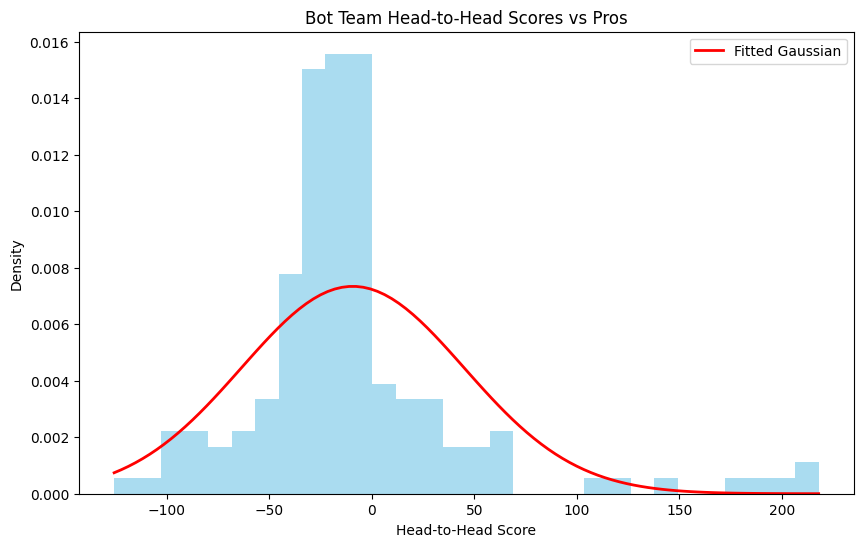

The average of 'head_to_head' is: -9.24


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming df_top_bot_pro_forecasts is already defined and contains the 'head_to_head' column

# Extract the 'head_to_head' data
data = df_top_bot_pro_forecasts['head_to_head']


# Calculate the mean and standard deviation
mean = np.mean(data)
std = np.std(data)

# Create the histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(data, bins=30, density=True, alpha=0.7, color='skyblue')

# Generate points for the fitted Gaussian curve
x = np.linspace(min(data), max(data), 100)
y = norm.pdf(x, mean, std)

# Plot the fitted Gaussian curve
plt.plot(x, y, 'r-', linewidth=2, label='Fitted Gaussian')

# Customize the plot
plt.title('Bot Team Head-to-Head Scores vs Pros')
plt.xlabel('Head-to-Head Score')
plt.ylabel('Density')
plt.legend()

# Add text annotation for the mean
#plt.text(0.95, 0.95, f'Mean: {mean:.2f}', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='right')

# Display the plot
plt.show()

# Print the average
print(f"The average of 'head_to_head' is: {mean:.2f}")

In [ ]:
top_10_bots[:9]


['FJ_Researcher01+bot',
 'Jay_Bailey_Bot',
 'pgodzinai',
 'histerio',
 'annabot',
 'RonanMcGovern',
 'twsummerbot',
 'archipelago',
 'mf-bot-1']

In [ ]:

df3 = df_top_bot_pro_forecasts.copy()

df3 = df3[['head_to_head', 'question_weight']]
df3 = df3.dropna()
df3 = df3.reset_index(drop=True)
weighted_score = (df3['head_to_head'] * df3['question_weight']).sum()
weighted_count = df3['question_weight'].sum()
weighted_average = weighted_score / weighted_count
weighted_std_dev = np.sqrt(((df3['head_to_head'] - weighted_average) ** 2 * df3['question_weight']).sum() / (weighted_count - 1))
std_error = weighted_std_dev / np.sqrt(weighted_count)
t_statistic = (weighted_average - 0) / std_error
if weighted_count > 2:
  t_crit = t_critical_value(weighted_count - 1)
  # 95% confidence that the true mean is between lower and upper bounds
  upper_bound = weighted_average + t_crit * std_error
  lower_bound = weighted_average - t_crit * std_error
  # 1.96 sigma for a normal Gaussian correponds to 97.5th percentile
  # Normalization below
  cdf = norm.cdf(t_statistic * 1.96 / t_crit)
else:
  t_crit = np.NaN
  upper_bound = np.NaN
  lower_bound = np.NaN
  cdf = np.NaN

df_bot_team_h2h = pd.DataFrame()

df_bot_team_h2h.loc[bot, 'W_score'] = weighted_score
df_bot_team_h2h.loc[bot, 'W_count'] = weighted_count
df_bot_team_h2h.loc[bot, 'W_ave'] = weighted_average
df_bot_team_h2h.loc[bot, 'W_stdev'] = weighted_std_dev
df_bot_team_h2h.loc[bot, 'std_err'] = std_error
df_bot_team_h2h.loc[bot, 't_stat'] = t_statistic
df_bot_team_h2h.loc[bot, 't_crit'] = t_crit
df_bot_team_h2h.loc[bot, 'upper_bound'] = upper_bound
df_bot_team_h2h.loc[bot, 'lower_bound'] = lower_bound
df_bot_team_h2h.loc[bot, 'cdf'] = cdf * 100

print(df_bot_team_h2h)

             W_score     W_count      W_ave    W_stdev   std_err    t_stat  \
acm_bot -1274.389482  113.172095 -11.260633  56.495054  5.310565 -2.120421   

         t_crit  upper_bound  lower_bound       cdf  
acm_bot   1.984    -0.724472   -21.796795  1.809569  


In [ ]:
df_sorted = df_top_bot_pro_forecasts.sort_values(by='head_to_head')

df_top5 = df_sorted.head(5)
df_bottom5 = df_sorted.tail(5)

print("Top 5:")
#print(df_top5)

print(df_top5[['title', 'bot_team_median', 'pro_median', 'resolution_internal', 'head_to_head']])

print("\nBottom 5:")
#print(df_bottom5)

print(df_bottom5[['title', 'bot_team_median', 'pro_median', 'resolution_internal', 'head_to_head']])

Top 5:
                                                 title  bot_team_median  \
79   Will Donald Trump have more than 15 million Ti...           0.7450   
10   Will Intel get dropped from the Dow Jones Indu...           0.7230   
16   Will Edmundo González be deprived of liberty b...           0.7000   
115  Will at least 5 major hurricanes occur in the ...           0.7200   
111  Will the Atlantic Ocean's daily mean sea surfa...           0.7265   

     pro_median  resolution_internal  head_to_head  
79        0.105                  0.0   -125.556017  
10        0.170                  0.0   -109.740819  
16        0.195                  0.0    -98.705980  
115       0.250                  0.0    -98.528360  
111       0.300                  0.0    -93.977871  

Bottom 5:
                                                 title  bot_team_median  \
140  Will exactly 1 Starship launch reach an altitu...             0.38   
38   Will Big Lots file for bankruptcy before Septe...         

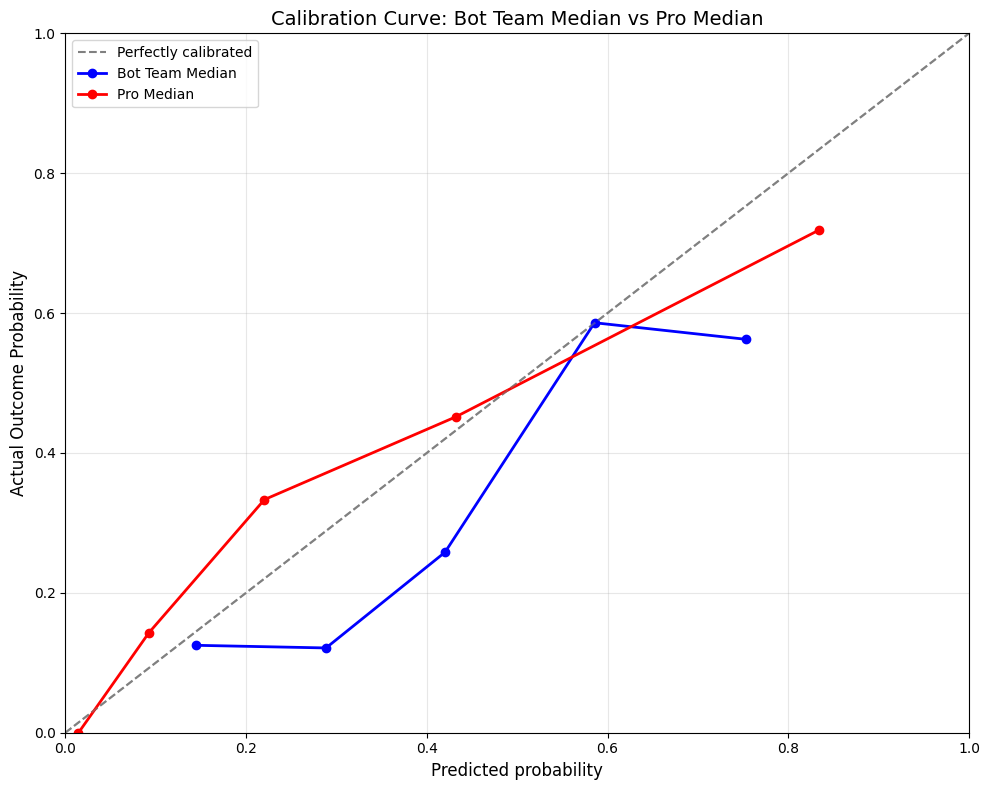

In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import numpy as np

# Function to plot calibration curve
def plot_calibration_curve(df, column_name, label, color):
    # Extract actual outcomes and predictions
    y_true = df['resolution_internal']
    y_pred = df[column_name]

    # Calculate calibration curve
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=5, strategy='quantile')

    # Plot calibration curve
    plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label=label, color=color)

# Set up the plot
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

# Plot calibration curves for bot_team_median and pro_median
plot_calibration_curve(df_top_bot_pro_forecasts, 'bot_team_median', 'Bot Team Median', 'blue')
plot_calibration_curve(df_top_bot_pro_forecasts, 'pro_median', 'Pro Median', 'red')

# Customize the plot
plt.xlabel('Predicted probability', fontsize=12)
plt.ylabel('Actual Outcome Probability', fontsize=12)
plt.title('Calibration Curve: Bot Team Median vs Pro Median', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add diagonal line for perfect calibration
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.5)

# Set axis limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Assuming df_top_bot_pro_forecasts is already defined

def calculate_confidence(predictions, outcomes):
    """
    Calculate over- or under-confidence for a set of predictions.

    :param predictions: Series of predicted probabilities
    :param outcomes: Series of actual outcomes (0 or 1)
    :return: Confidence score (positive for overconfidence, negative for underconfidence)
    """
    # Bin predictions into 10 equally spaced bins
    bins = pd.cut(predictions, bins=10)

    # Calculate mean prediction and actual outcome for each bin
    grouped = pd.DataFrame({'prediction': predictions, 'outcome': outcomes}).groupby(bins)
    mean_prediction = grouped['prediction'].mean()
    mean_outcome = grouped['outcome'].mean()

    # Calculate the difference between mean prediction and mean outcome
    confidence_diff = mean_prediction - mean_outcome

    # Return the average difference (excluding NaN values)
    return np.nanmean(confidence_diff)

# Calculate confidence scores for bot_team_median and pro_median
bot_confidence = calculate_confidence(df_top_bot_pro_forecasts['bot_team_median'], df_top_bot_pro_forecasts['resolution_internal'])
pro_confidence = calculate_confidence(df_top_bot_pro_forecasts['pro_median'], df_top_bot_pro_forecasts['resolution_internal'])

print(f"Bot team confidence score: {bot_confidence:.4f}")
print(f"Pro team confidence score: {pro_confidence:.4f}")

# Interpret the results
def interpret_confidence(score):
    if score > 0:
        return f"Overconfident by {score:.4f}"
    elif score < 0:
        return f"Underconfident by {abs(score):.4f}"
    else:
        return "Perfectly calibrated"

print(f"Bot team is {interpret_confidence(bot_confidence)}")
print(f"Pro team is {interpret_confidence(pro_confidence)}")

Bot team confidence score: 0.1065
Pro team confidence score: 0.0140
Bot team is Overconfident by 0.1065
Pro team is Overconfident by 0.0140


<ipython-input-29-920f177f3730>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = pd.DataFrame({'prediction': predictions, 'outcome': outcomes}).groupby(bins)


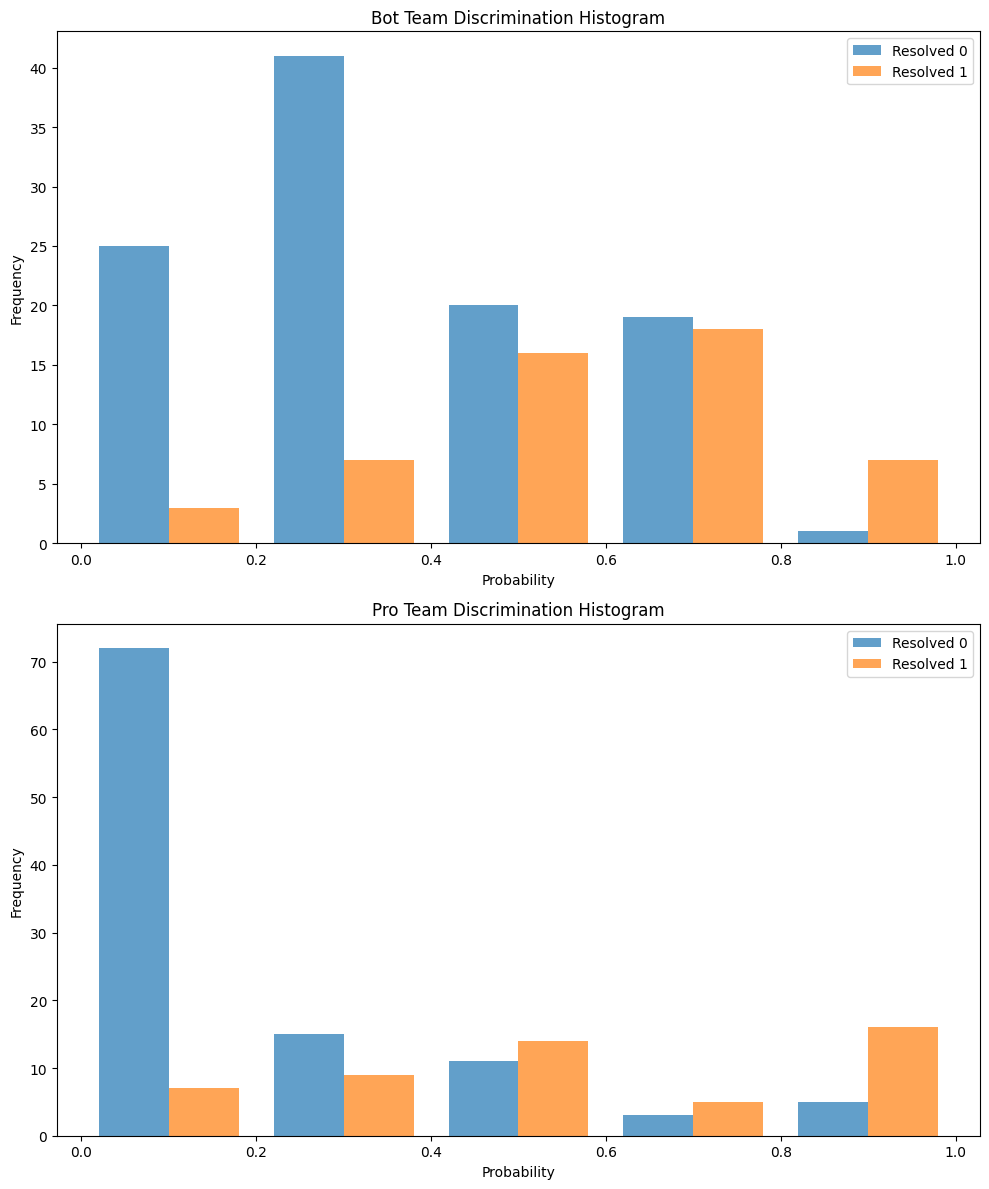

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_top_bot_pro_forecasts is already loaded
# If not, you would load it here:
# df_top_bot_pro_forecasts = pd.read_csv('your_data.csv')

def create_discrimination_histogram(df, bot_col, pro_col, resolution_col):
    # Create figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Define bin edges
    #bins = np.linspace(0, 1, 11)
    bins = np.linspace(0, 1, 6)

    # Bot team histogram
    ax1.hist([df[df[resolution_col] == 0][bot_col],
              df[df[resolution_col] == 1][bot_col]],
             bins=bins, label=['Resolved 0', 'Resolved 1'], alpha=0.7)
    ax1.set_title('Bot Team Discrimination Histogram')
    ax1.set_xlabel('Probability')
    ax1.set_ylabel('Frequency')
    ax1.legend()

    # Pro team histogram
    ax2.hist([df[df[resolution_col] == 0][pro_col],
              df[df[resolution_col] == 1][pro_col]],
             bins=bins, label=['Resolved 0', 'Resolved 1'], alpha=0.7)
    ax2.set_title('Pro Team Discrimination Histogram')
    ax2.set_xlabel('Probability')
    ax2.set_ylabel('Frequency')
    ax2.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame and column names
create_discrimination_histogram(df_top_bot_pro_forecasts,
                                'bot_team_median',
                                'pro_median',
                                'resolution_internal')

In [ ]:

# Calculate average forecasts for resolved 1 and 0 for bots
bot_avg_1 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution_internal'] == 1]['bot_team_median'].mean()
bot_avg_0 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution_internal'] == 0]['bot_team_median'].mean()

# Calculate average forecasts for resolved 1 and 0 for pros
pro_avg_1 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution_internal'] == 1]['pro_median'].mean()
pro_avg_0 = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['resolution_internal'] == 0]['pro_median'].mean()

# Calculate the differences
bot_difference = bot_avg_1 - bot_avg_0
pro_difference = pro_avg_1 - pro_avg_0

print(f"Bot average forecast difference (1 - 0): {bot_difference:.4f}")
print(f"Pro average forecast difference (1 - 0): {pro_difference:.4f}")

# Calculate the difference between pro and bot differences
pro_bot_difference = pro_difference - bot_difference
print(f"Difference between pro and bot differences: {pro_bot_difference:.4f}")

Bot average forecast difference (1 - 0): 0.2082
Pro average forecast difference (1 - 0): 0.3596
Difference between pro and bot differences: 0.1514


In [ ]:
print(df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['bot_question_id'] == '26098'])

Empty DataFrame
Columns: [pro_question_id, title, resolution_internal, scheduled_close_time, bot_question_id, question_weight, bot_team_median, pro_median, head_to_head, weighted_score]
Index: []


In [ ]:
# Assuming df_top_bot_pro_forecasts is already loaded

def get_forecast(question_id):
    forecast = df_top_bot_pro_forecasts[df_top_bot_pro_forecasts['bot_question_id'] == question_id]['bot_team_median'].values
    return forecast[0] if len(forecast) > 0 else np.nan

def process_scope_questions(bot_scope_questions):
    scope_ratios = []

    for question_tuple in bot_scope_questions:
        forecasts = [get_forecast(qid) for qid in question_tuple]

        print(f"Forecasts for questions {question_tuple}: {forecasts}")

        if not any(np.isnan(forecasts)):
            scope_ratio = forecasts[0] / (forecasts[1] + forecasts[2])
            print(f"Scope ratio: {scope_ratio:.4f}")
            scope_ratios.append(scope_ratio)
        else:
            print("Unable to calculate scope ratio due to missing forecast(s)")

        print()  # Empty line for readability

    return scope_ratios

# Process the bot_scope_questions
scope_ratios = process_scope_questions(bot_scope_questions)

# Calculate and print the average scope ratio
if scope_ratios:
    average_scope_ratio = sum(scope_ratios) / len(scope_ratios)
    print(f"Average scope ratio: {average_scope_ratio:.4f}")
else:
    print("No valid scope ratios to average")

Forecasts for questions (26019, 26017, 26018): [0.62, 0.38, 0.36]
Scope ratio: 0.8378

Forecasts for questions (26098, 26096, 26097): [nan, nan, nan]
Unable to calculate scope ratio due to missing forecast(s)

Forecasts for questions (26159, 26158, 26157): [0.599, 0.435, 0.295]
Scope ratio: 0.8205

Forecasts for questions (26194, 26195, 26196): [nan, nan, nan]
Unable to calculate scope ratio due to missing forecast(s)

Forecasts for questions (26006, 26005, 26004): [0.7166666666666666, 0.355, 0.525]
Scope ratio: 0.8144

Forecasts for questions (26642, 26643, 26644): [nan, nan, nan]
Unable to calculate scope ratio due to missing forecast(s)

Forecasts for questions (26700, 26701, 26702): [0.86, 0.794, 0.33100000000000007]
Scope ratio: 0.7644

Forecasts for questions (27261, 27262, 27263): [nan, nan, nan]
Unable to calculate scope ratio due to missing forecast(s)

Average scope ratio: 0.8093


In [ ]:
print(df_top_bot_pro_forecasts)

     pro_question_id                                              title  \
0              28066  Will the lithium carbonate (CNY/T) price fall ...   
1              28065  Will AfD's vote share be less than or equal to...   
2              28064  Will AfD's vote share be more than 28% and les...   
3              28063  Will AfD's vote share be more than 30% and les...   
4              28062  Will AfD's vote share be more than 32% in the ...   
..               ...                                                ...   
152            25891  Will Joe Biden announce before July 31 2024 th...   
153            25890  Will the time gap between the first and second...   
154            25889  Will the Real-time Sahm Rule Recession Indicat...   
155            25888  Will 4 or more goals be scored in the two semi...   
156            25887  On July 17 2024 will Nvidia's market capitaliz...   

     resolution_internal       scheduled_close_time  bot_question_id  \
0                    0.0  2

In [ ]:
# Calculate weighted number of 1 resolutions
weighted_ones = np.sum(
    df_top_bot_pro_forecasts['resolution_internal'] *
    df_top_bot_pro_forecasts['question_weight']
)

# Calculate weighted number of 0 resolutions
weighted_zeros = np.sum(
    (1 - df_top_bot_pro_forecasts['resolution_internal']) *
    df_top_bot_pro_forecasts['question_weight']
)

print(f"Weighted number of 1 resolutions: {weighted_ones}")
print(f"Weighted number of 0 resolutions: {weighted_zeros}")

print(f"Average 1 resolutions: {weighted_ones / (weighted_zeros + weighted_ones)}")

Weighted number of 1 resolutions: 35.20515107390773
Weighted number of 0 resolutions: 77.9669438149629
Average 1 resolutions: 0.31107625168976005
